# Movie Recommender

In [1]:
import pandas as pd

## data paths

In [2]:
#data paths
links_csv = "data/links.csv"
ratings_csv = "data/ratings.csv"
imdb_tsv = "data/title.basics.tsv"
imdb_ratings_tsv = "data/title.ratings.tsv"
tmdb_csv = "data/tmdb_movies_data.csv"

## movie lens data

In [3]:
#links.csv (imdb & tmdb ids)
links_cols = ['movieLensID', 'IMDbID', 'TMDbID']
links = pd.read_csv(links_csv, header=0, names=links_cols)

In [4]:
#change imdb id so it aligns with imdb data
#imdb id must be tt, then 7 digits
links['IMDbID'] = links['IMDbID'].apply(str)
for i in links.index:
    temp = links['IMDbID'][i]
    while len(temp) < 7:
        temp = "0" + temp
    newID = "tt" + temp
    links.at[i,'IMDbID'] = newID

In [5]:
#change tmdb id from float to int
links['TMDbID'] = links['TMDbID'].astype('Int64')

In [6]:
#ratings.csv (ratings info)
ratings_cols = ['userID', 'movieLensID', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_csv, header=0, names=ratings_cols)
ratings = ratings.drop('timestamp',axis=1)

In [7]:
links.head()

,movieLensID,IMDbID,TMDbID
0,1,tt0114709,862
1,2,tt0113497,8844
2,3,tt0113228,15602
3,4,tt0114885,31357
4,5,tt0113041,11862


In [8]:
ratings.head()

,userID,movieLensID,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
ratings_linked = pd.merge(ratings, links, on='movieLensID', how='inner')

In [10]:
ratings_linked.head()

,userID,movieLensID,rating,IMDbID,TMDbID
0,1,1,4.0,tt0114709,862
1,5,1,4.0,tt0114709,862
2,7,1,4.5,tt0114709,862
3,15,1,2.5,tt0114709,862
4,17,1,4.5,tt0114709,862


## IMDb data

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [12]:
#imdb tsv
imdb_cols = ['IMDbID','type','title','originalTitle','adult','year','endYear','runtime','genres']
imdb_df = pd.read_table(imdb_tsv, sep='\t', names=imdb_cols, header=0)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
#filter for only movies
imdb_df = imdb_df[imdb_df.type=="movie"]

In [14]:
#clean adult column so it only contains 0 & 1
for i in imdb_df.index:
    a = imdb_df['adult'][i]
    if a!=0 or a!=1:
        if a == '1':
            imdb_df.at[i,'adult'] = 1
        else:
            imdb_df.at[i,'adult'] = 0

In [15]:
#filter out adult
imdb_df = imdb_df[imdb_df.adult==0]

In [16]:
#drop unnecessary columns
imdb_df = imdb_df.drop(['type','originalTitle','adult','year','endYear','runtime'],axis=1)

#### functions for transforming data

In [17]:
#function for converting strings to lists
def stringToList(df,col,sep):
    for i in df.index:
        string = df[col][i]
        resultList = string.split(sep)
        df.at[i,col] = resultList

In [18]:
def binary_array(df,col,newCol):
    df[newCol] = df[col]
    arr = mlb.fit_transform(df[newCol])
    index = 0
    for i in df.index:
        df.at[i,newCol] = arr[index]
        index += 1

#### continue w cleaning imdb

In [19]:
#separate genres into lists ("Adventure,Comedy" to ["Adventure","Comedy"])
stringToList(imdb_df,'genres',',')

In [20]:
#binarize genres
binary_array(imdb_df,'genres','genres_binary')

In [21]:
imdb_df.head()

,IMDbID,title,genres,genres_binary
498,tt0000502,Bohemios,[\N],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
570,tt0000574,The Story of the Kelly Gang,"[Action, Adventure, Biography]","[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
587,tt0000591,The Prodigal Son,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
610,tt0000615,Robbery Under Arms,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
625,tt0000630,Hamlet,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


#### add imdb ratings

In [22]:
#imdb ratings data
imdb_ratings_cols = ['IMDbID','IMDb_rating','IMDb_votes']
imdb_ratings_df = pd.read_table(imdb_ratings_tsv, sep='\t', names=imdb_ratings_cols, header=0)

In [23]:
#merge ratings data
imdb_ratings_merged = pd.merge(imdb_df, imdb_ratings_df, on='IMDbID', how='inner')

In [24]:
imdb_ratings_merged.head()

,IMDbID,title,genres,genres_binary,IMDb_rating,IMDb_votes
0,tt0000502,Bohemios,[\N],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.5,14
1,tt0000574,The Story of the Kelly Gang,"[Action, Adventure, Biography]","[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.1,739
2,tt0000591,The Prodigal Son,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.2,16
3,tt0000615,Robbery Under Arms,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4.5,23
4,tt0000630,Hamlet,[Drama],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.8,23


## TMDb data

In [25]:
tmdb_df = pd.read_csv(tmdb_csv, header=0)
tmdb_df = tmdb_df.rename(columns={'id':'TMDbID','imdb_id':'IMDbID','original_title':'title',
                                  'vote_count':'TMDb_votes','vote_average':'TMDb_rating'})

In [26]:
#drop unnecessary columns
tmdb_df = tmdb_df.drop(['popularity','budget','revenue','homepage','tagline','overview','runtime',
                        'genres','production_companies','release_date','release_year','budget_adj',
                        'revenue_adj'],axis=1)

In [27]:
#fill empty casts, keywords, and directors with empty strings
tmdb_df.cast = tmdb_df.cast.fillna('')
tmdb_df.keywords = tmdb_df.keywords.fillna('')
tmdb_df.director = tmdb_df.director.fillna('')

In [28]:
#transform cast to binary list
stringToList(tmdb_df,'cast','|')
binary_array(tmdb_df,'cast','cast_binary')

In [29]:
#transform keywords to binary list
stringToList(tmdb_df,'keywords','|')
binary_array(tmdb_df,'keywords','keywords_binary')

In [30]:
#transform directors to binary list
stringToList(tmdb_df,'director','|')
binary_array(tmdb_df,'director','director_binary')

In [31]:
tmdb_df.head()

,TMDbID,IMDbID,title,cast,director,keywords,TMDb_votes,TMDb_rating,cast_binary,keywords_binary,director_binary
0,135397,tt0369610,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",[Colin Trevorrow],"[monster, dna, tyrannosaurus rex, velociraptor...",5562,6.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,76341,tt1392190,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",[George Miller],"[future, chase, post-apocalyptic, dystopia, au...",6185,7.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,262500,tt2908446,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",[Robert Schwentke],"[based on novel, revolution, dystopia, sequel,...",2480,6.3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,140607,tt2488496,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",[J.J. Abrams],"[android, spaceship, jedi, space opera, 3d]",5292,7.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,168259,tt2820852,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",[James Wan],"[car race, speed, revenge, suspense, car]",2947,7.3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## merging

### merge imdb with ratings and tmdb

In [32]:
imdb_tmdb = pd.merge(imdb_ratings_merged, tmdb_df, on='IMDbID', how='inner')
imdb_tmdb = imdb_tmdb.drop('title_y',axis=1).rename(columns={'title_x':'title'})

In [33]:
imdb_tmdb.head()

,IMDbID,title,genres,genres_binary,IMDb_rating,IMDb_votes,TMDbID,cast,director,keywords,TMDb_votes,TMDb_rating,cast_binary,keywords_binary,director_binary
0,tt0035423,Kate & Leopold,"[Comedy, Fantasy, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",6.4,82109,11232,"[Meg Ryan, Hugh Jackman, Liev Schreiber, Breck...",[James Mangold],"[lover (female), love of one's life, time trav...",248,5.8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,tt0052646,The Brain That Wouldn't Die,"[Horror, Sci-Fi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",4.5,6801,33468,"[Jason Evers, Virginia Leith, Doris Brent, Aud...",[Joseph Green],"[transplantation, experiment, mutant, brain, f...",12,4.9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,tt0053559,13 Ghosts,"[Horror, Mystery]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",6.1,6059,29756,"[Charles Herbert, Jo Morrow, Martin Milner, Ro...",[William Castle],[haunted house],12,5.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,tt0053580,The Alamo,"[Adventure, Drama, History]","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",6.8,15401,11209,"[John Wayne, Richard Widmark, Laurence Harvey,...",[John Wayne],"[texas, assault, alamo, mexican, mexican army]",27,6.2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,tt0053604,The Apartment,"[Comedy, Drama, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.3,173892,284,"[Jack Lemmon, Shirley MacLaine, Fred MacMurray...",[Billy Wilder],"[new york, new year's eve, lovesickness, age d...",235,7.9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### merge imdb_tmdb with movielens ID

In [34]:
imdb_tmdb_movieLens = pd.merge(links,imdb_tmdb,on='IMDbID',how='inner')
imdb_tmdb_movieLens = imdb_tmdb_movieLens.drop(['TMDbID_y'],axis=1).rename(columns={'TMDbID_x':'TMDbID'})

In [35]:
imdb_tmdb_movieLens.head()

,movieLensID,IMDbID,TMDbID,title,genres,genres_binary,IMDb_rating,IMDb_votes,cast,director,keywords,TMDb_votes,TMDb_rating,cast_binary,keywords_binary,director_binary
0,1,tt0114709,862,Toy Story,"[Adventure, Animation, Comedy]","[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.3,936979,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],"[jealousy, toy, boy, friendship, friends]",3141,7.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,tt0113497,8844,Jumanji,"[Adventure, Comedy, Family]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",7.0,327695,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],"[board game, disappearance, based on a childre...",1105,6.6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,tt0113228,15602,Grumpier Old Men,"[Comedy, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.7,26209,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],"[fishing, best friend, duringcreditsstinger, o...",45,6.7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,tt0114885,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6.0,10547,"[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker],"[based on novel, interracial relationship, sin...",18,6.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,tt0113041,11862,Father of the Bride Part II,"[Comedy, Family, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",6.1,36802,"[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer],"[baby, midlife crisis, confidence, aging, daug...",82,5.7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### filter ratings data

In [36]:
movieLensIDs = imdb_tmdb_movieLens.movieLensID.unique()
for i in ratings_linked.index:
    movieID = ratings_linked['movieLensID'][i]
    if movieID not in movieLensIDs:
        ratings_linked = ratings_linked.drop(i)

## final data sets to use

##### links
movieLensID, IMDbID, TMDbID
##### ratings_linked
userID, movieLensID, rating, IMDbID, TMDbID
##### imdb_tmdb
IMDbID, title, genres, genres_binary, IMDb_rating, IMDb_votes, TMDbID, cast, director, keywords, TMDb_votes, TMDb_rating, cast_binary, keywords_binary, director_binary
##### imdb_tmdb_movieLens
movieLensID, IMDbID, TMDbID, title, genres, genres_binary, IMDb_rating, IMDb_votes, cast, director, keywords, TMDb_votes, TMDb_rating, cast_binary, keywords_binary, director_binary

In [48]:
import dataframe_image as dfi

In [ ]:
#export all datasets as images for report
dfi.export(links.head(), 'links.png')
dfi.export(ratings.head(), 'ratings.png')
dfi.export(ratings_linked.head(), 'ratings_linked.png')
dfi.export(imdb_df.head(), 'imdb.png')
dfi.export(imdb_ratings_merged.head(), 'imdb_ratings.png')
dfi.export(tmdb_df.head(), 'tmdb.png')
dfi.export(imdb_tmdb.head(), 'imdb_tmdb.png')
dfi.export(imdb_tmdb_movieLens.head(), 'imdb_tmdb_movieLens.png')

## KNN

In [37]:
from scipy import spatial
import numpy as np
from sklearn.metrics import mean_squared_error as mse

In [38]:
def similarity(attributeList, df1, df2, i, j):
    sim = 0
    rmse = 0
    for attribute in attributeList:
        a = df1[attribute][i]
        b = df2[attribute][j]
        sim += spatial.distance.cosine(a,b)
        rmse += np.sqrt(mse(a,b))
    sim = sim/4
    rmse = rmse/4
    return sim, rmse

In [39]:
def recommend_movies(user_df, k, attributes):
    neighbors = pd.DataFrame(columns=['IMDbID','similarity','RMSE'])
    
    for i in user_df.index:
        user_movieID = user_df['IMDbID'][i]
        
        for j in imdb_tmdb.index:
            movieID = imdb_tmdb['IMDbID'][j]
            
            if movieID not in user_movies:
                sim, rmse = similarity(attributes, user_df, imdb_tmdb, i, j)
                neighbors = neighbors.append({'IMDbID':movieID, 'similarity':sim, 'RMSE':rmse}, ignore_index=True)
    
    neighbors = neighbors.sort_values(by='similarity')
    neighbors = neighbors.head(k)
    return neighbors

### testing !

In [54]:
#inputs
userID = int(input("Hello! What is your user id? (num between 1 and 610): "))
user_ratings = ratings_linked[ratings_linked.userID == userID].sort_values(by='rating',ascending=False)
user_movies = user_ratings.IMDbID.unique()

topMovies = int(input("You've rated " + str(len(user_ratings)) + 
                      " movies. How many of your top rated movies would you like us to compare?: "))
user_ratings_ids = user_ratings.drop(['userID','movieLensID','rating','TMDbID'],axis=1).head(topMovies)
user_top = pd.merge(user_ratings_ids, imdb_tmdb_movieLens, on='IMDbID', how='inner')

recommendMovies = int(input("How many movies would you like us to recommend?: "))

attributes = ['genres_binary','cast_binary','director_binary','keywords_binary']

Hello! What is your user id? (num between 1 and 610): 225
You've rated 71 movies. How many of your top rated movies would you like us to compare?: 5
How many movies would you like us to recommend?: 10


In [55]:
#run recommender
recommend = recommend_movies(user_top, recommendMovies, attributes)
recommend

,IMDbID,similarity,RMSE
4932,tt0424345,0.216667,0.008196
3829,tt0261392,0.300000,0.010529
11514,tt0104694,0.483333,0.078746
12212,tt0117372,0.500000,0.014638
6040,tt1007028,0.523223,0.059516
11872,tt0110971,0.545876,0.061062
2900,tt0118842,0.555662,0.078746
2610,tt0113749,0.573223,0.060121
12953,tt0200027,0.583333,0.080291
38327,tt0077766,0.595876,0.062843


In [56]:
#user's top movies output
user_top_output = user_top.drop(['movieLensID','TMDbID','genres_binary','IMDb_rating','IMDb_votes','TMDb_votes',
                                 'TMDb_rating','cast_binary','keywords_binary','director_binary'],axis=1)
user_top_output

,IMDbID,title,genres,cast,director,keywords
0,tt0109445,Clerks,[Comedy],"[Brian O'Halloran, Jeff Anderson, Jason Mewes,...",[Kevin Smith],"[salesclerk, loser, aftercreditsstinger]"
1,tt0094737,Big,"[Comedy, Drama, Fantasy]","[Tom Hanks, Elizabeth Perkins, Robert Loggia, ...",[Penny Marshall],"[baseball, co-worker, bronx, pinball machine, ..."
2,tt0080761,Friday the 13th,"[Horror, Mystery, Thriller]","[Betsy Palmer, Adrienne King, Harry Crosby, La...",[Sean S. Cunningham],"[drowning, lake, cabin, cult, revenge]"
3,tt0113118,Friday,"[Comedy, Drama]","[Ice Cube, Chris Tucker, Nia Long, Tommy 'Tiny...",[F. Gary Gray],"[rap, parents kids relationship, rapper, job]"
4,tt0073195,Jaws,"[Adventure, Thriller]","[Roy Scheider, Robert Shaw, Richard Dreyfuss, ...",[Steven Spielberg],"[fishing, atlantic ocean, bathing, shipwreck, ..."


In [57]:
#recommender output
recommended_links = pd.merge(recommend, links, on='IMDbID', how='inner')
recommended = pd.merge(recommended_links, imdb_tmdb_movieLens, on='IMDbID', how='inner')
recommended_output = recommended.drop(['similarity','RMSE','movieLensID_x','TMDbID_x','movieLensID_y','TMDbID_y',
                                       'genres_binary','IMDb_rating','IMDb_votes','TMDb_votes','TMDb_rating',
                                       'cast_binary','keywords_binary','director_binary'],axis=1)
recommended_output

,IMDbID,title,genres,cast,director,keywords
0,tt0424345,Clerks II,[Comedy],"[Brian O'Halloran, Jeff Anderson, Jason Mewes,...",[Kevin Smith],"[independent film, aftercreditsstinger, during..."
1,tt0261392,Jay and Silent Bob Strike Back,[Comedy],"[Kevin Smith, Jason Mewes, Ben Affleck, Jeff A...",[Kevin Smith],"[film making, jay and silent bob, self mocking..."
2,tt0104694,A League of Their Own,"[Comedy, Drama, Sport]","[Tom Hanks, Geena Davis, Madonna, Lori Petty, ...",[Penny Marshall],"[baseball, world war ii, sport, baseball playe..."
3,tt0117372,The Preacher's Wife,"[Comedy, Drama, Fantasy]","[Denzel Washington, Whitney Houston, Courtney ...",[Penny Marshall],"[angel, church choir, gospel, reverend, crisis..."
4,tt1007028,Zack and Miri Make a Porno,"[Comedy, Romance]","[Seth Rogen, Elizabeth Banks, Jennifer Schwalb...",[Kevin Smith],"[pornography, love of one's life, platonic lov..."
5,tt0110971,Renaissance Man,"[Comedy, Drama]","[Danny DeVito, Mark Wahlberg, Gregory Hines, J...",[Penny Marshall],"[vietnam veteran, commercial, advertising expe..."
6,tt0118842,Chasing Amy,"[Comedy, Drama, Romance]","[Ben Affleck, Joey Lauren Adams, Jason Lee, Dw...",[Kevin Smith],"[new jersey, coming out, love of one's life, b..."
7,tt0113749,Mallrats,"[Comedy, Romance]","[Jason Lee, Jeremy London, Shannen Doherty, Cl...",[Kevin Smith],"[sex, game show, slacker, comic, shopping]"
8,tt0200027,Riding in Cars with Boys,"[Biography, Comedy, Drama]","[Drew Barrymore, Steve Zahn, Adam Garcia, Brit...",[Penny Marshall],"[baby, becoming an adult, puberty, dream, drug..."
9,tt0077766,Jaws 2,"[Adventure, Horror, Thriller]","[Roy Scheider, Lorraine Gary, Murray Hamilton,...",[Jeannot Szwarc],"[mayor, island, police chief, sailing, boat ac..."


In [ ]:
dfi.export(recommend, 'recommended.png')
dfi.export(user_top_output, 'user_top_output.png')
dfi.export(recommended_output, 'recommended_output.png')

## results

### evaluation metrics

In [44]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [45]:
def eval_metrics(user_df, recommended_df, attributes):
    
    count = 0
    f1 = 0
    acc = 0
    prec = 0
    recall = 0

    for i in user_df.index:
        
        for j in recommended_df.index:
            
            f1_a = 0
            acc_a = 0
            prec_a = 0
            recall_a = 0
            
            for attribute in attributes:
                
                y_true = user_df.at[i, attribute]
                y_pred = recommended_df.at[j, attribute]
                
                f1_a += f1_score(y_true, y_pred, average='weighted')
                acc_a += accuracy_score(y_true, y_pred)
                prec_a += precision_score(y_true, y_pred, average='weighted')
                recall_a += recall_score(y_true, y_pred, average='weighted')
            
            f1 += (f1_a/len(attributes))
            acc += (acc_a/len(attributes))
            prec += (prec_a/len(attributes))
            recall += (recall_a/len(attributes))
            count += 1
    
    f1 = f1/count
    acc = acc/count
    prec = prec/count
    recall = recall/count
    
    return f1, acc, prec, recall

In [46]:
metrics = eval_metrics(user_top, recommended, attributes)
print("F1 score: " + str(metrics[0]))
print("Accuracy: " + str(metrics[1]))
print("Precision: " + str(metrics[2]))
print("Recall: " + str(metrics[3]))

F1 score: 0.9751964835896518
Accuracy: 0.9752010635291732
Precision: 0.9763319495131824
Recall: 0.9752010635291732


### testing multiple

In [47]:
import random

In [50]:
#generate 5 random users
users = [0,0,0,0,0]
for i in range(len(users)):
    users[i] = random.randint(1,610)
users

[586, 521, 267, 37, 265]

In [51]:
#run recommender for each user
recommender_metrics = pd.DataFrame(columns=['userID','f1','accuracy','precision','recall'])
attributes = ['genres_binary','cast_binary','director_binary','keywords_binary']

for user in users:
    
    #find user's top 5 rated movies
    user_ratings = ratings_linked[ratings_linked.userID == user].sort_values(by='rating',ascending=False)
    user_movies = user_ratings.IMDbID.unique()
    user_ratings_ids = user_ratings.drop(['userID','movieLensID','rating','TMDbID'],axis=1).head(5)
    user_top = pd.merge(user_ratings_ids, imdb_tmdb_movieLens, on='IMDbID', how='inner')
    
    #run recommender to recommend 10
    recommend = recommend_movies(user_top, 10, attributes)
    recommended_links = pd.merge(recommend, links, on='IMDbID', how='inner')
    recommended = pd.merge(recommended_links, imdb_tmdb_movieLens, on='IMDbID', how='inner')
    
    #calculate evaluation metrics
    metrics = eval_metrics(user_top, recommended, attributes)
    
    #append row with user id and metrics
    recommender_metrics = recommender_metrics.append({'userID':user, 'f1':metrics[0], 
                                                      'accuracy':metrics[1], 
                                                      'precision':metrics[2], 
                                                      'recall':metrics[3]}, ignore_index=True)

#convert userID column from float to int
recommender_metrics.userID = recommender_metrics.userID.astype(int)

In [52]:
recommender_metrics

,userID,f1,accuracy,precision,recall
0,586,0.970253,0.971860,0.969159,0.971860
1,521,0.983144,0.982433,0.984415,0.982433
2,267,0.969903,0.972029,0.968182,0.972029
3,37,0.974888,0.975893,0.974436,0.975893
4,265,0.972951,0.973466,0.972665,0.973466


In [ ]:
dfi.export(recommender_metrics, 'recommender_metrics.png')

In [73]:
recommender_metrics.describe()

,userID,f1,accuracy,precision,recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,335.200000,0.974228,0.975136,0.973772,0.975136
std,221.316967,0.005387,0.004387,0.006471,0.004387
min,37.000000,0.969903,0.971860,0.968182,0.971860
25%,265.000000,0.970253,0.972029,0.969159,0.972029
50%,267.000000,0.972951,0.973466,0.972665,0.973466
75%,521.000000,0.974888,0.975893,0.974436,0.975893
max,586.000000,0.983144,0.982433,0.984415,0.982433


### visualizations

#### cosine similarity matrix (based on user 225 - see kernels under testing !)

In [58]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [59]:
def plot_sim(df, attributes, fileName):
    #make cosine similarity matrix
    matrix = np.zeros([len(df),len(df)])
    for i in df.index:
        movie1 = df['IMDbID'][i]
        for j in df.index:
            movie2 = df['IMDbID'][j]
            if movie1 != movie2:
                sim, rmse = similarity(attributes, df, df, i, j)
                matrix[i][j] = sim
            else:
                continue
    
    #plot cosine similarity matrix
    labels = []
    for i in df.index:
        title = df['title'][i]
        labels.append(title)

    fig, ax = plt.subplots(figsize=(20,20))
    cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap)
    ax.grid(True)
    plt.title('Movie Similarity Matrix', fontsize=24)
    plt.xticks(range(len(df)), labels, rotation = 90)
    plt.yticks(range(len(df)), labels)
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    plt.savefig(fileName)
    plt.show()

In [60]:
#merge user top and recommend for cosine similarity matrix
recommend_ID = recommend.drop(['similarity','RMSE'],axis=1)
user_recommend_appended = user_ratings_ids.append(recommend_ID)
user_recommend = pd.merge(user_recommend_appended, imdb_tmdb_movieLens, on='IMDbID', how='inner')

In [61]:
#color for similarity plot
cmap = cm.get_cmap('gnuplot')

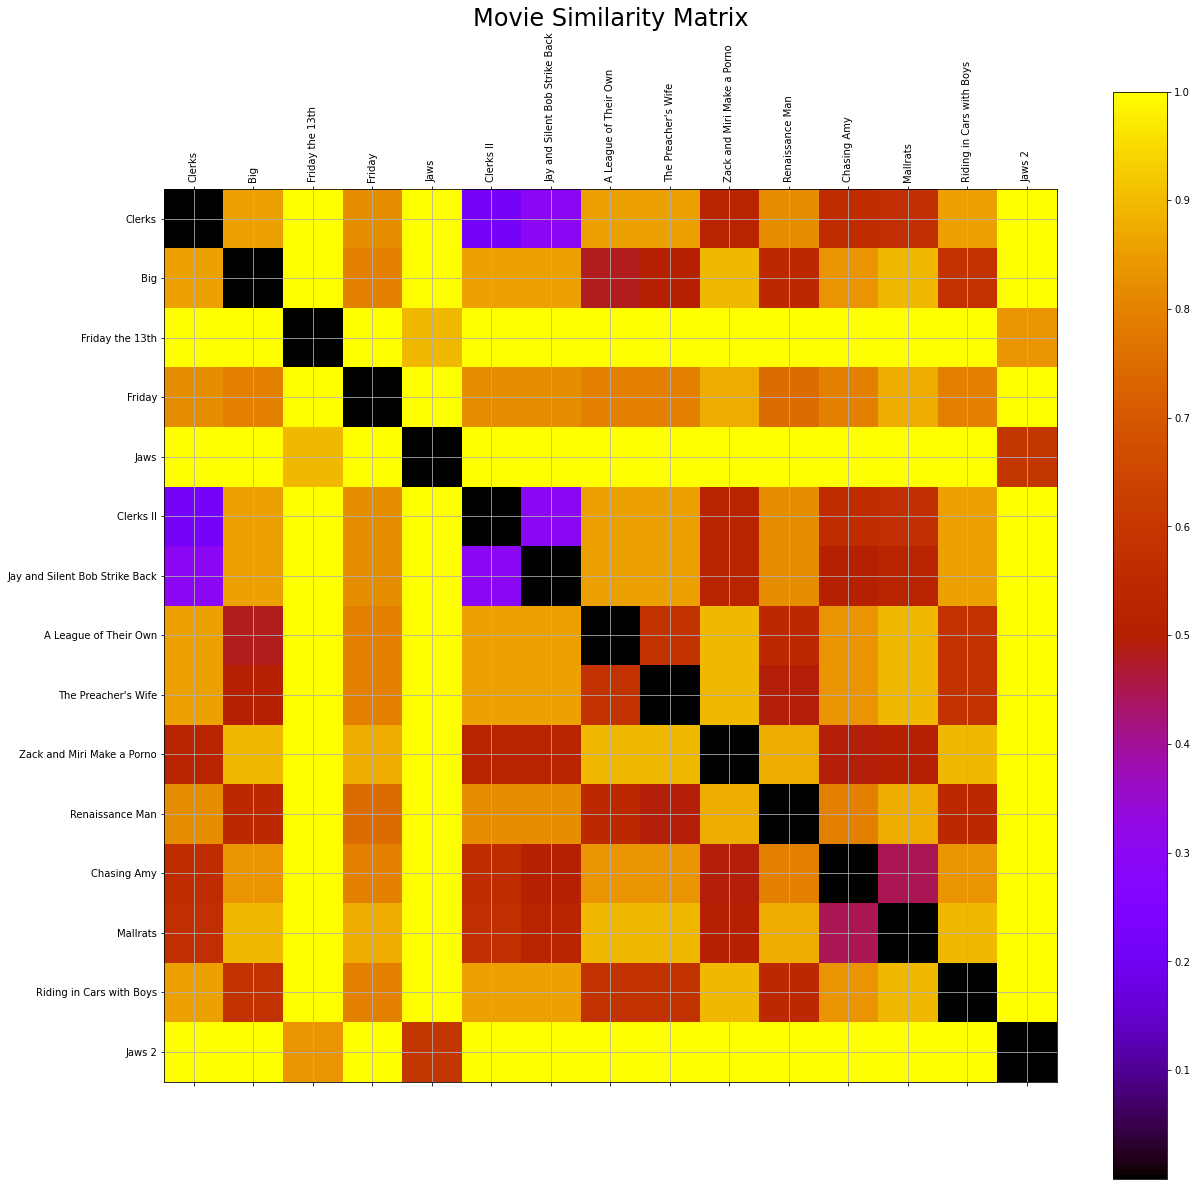

In [62]:
#cosine similarity matrix of user's movies and recommended movies
attributes = ['genres_binary','cast_binary','director_binary','keywords_binary']
plot_sim(user_recommend, attributes, 'moviesim1.png')

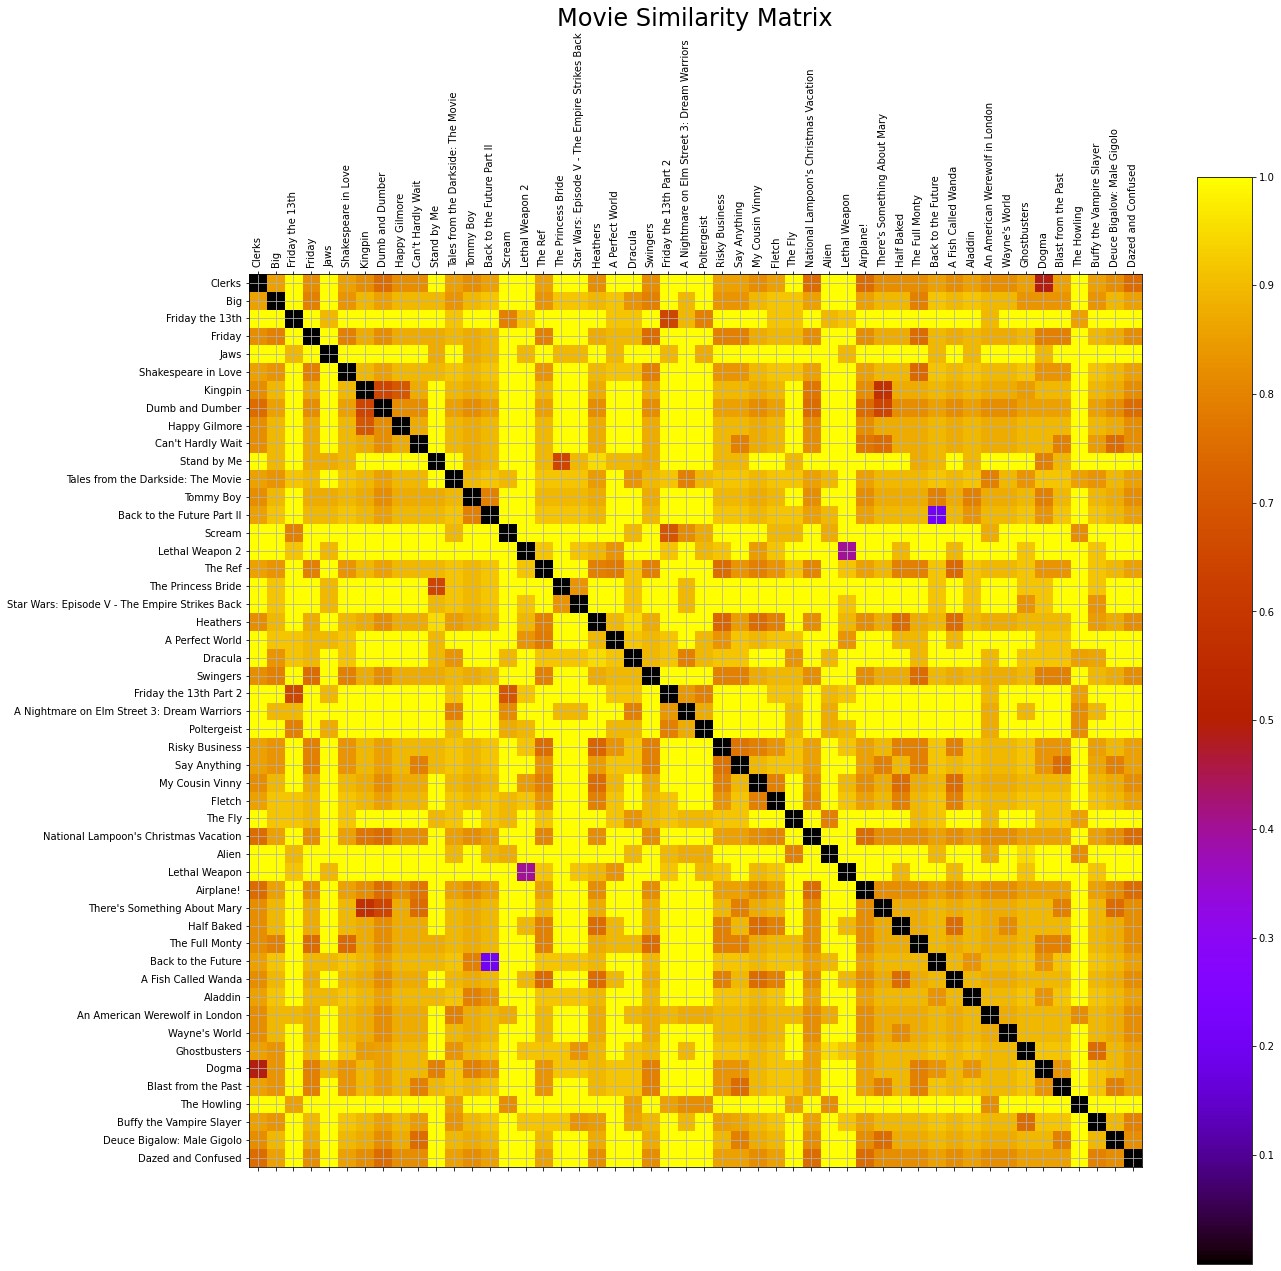

In [63]:
#similarity matrix of user's top n movies
user_top_movies = pd.merge(user_ratings, imdb_tmdb_movieLens, on='IMDbID', how='inner')
num = 50
if len(user_top_movies) > num:
    user_top_movies = user_top_movies.head(num)
plot_sim(user_top_movies, attributes, 'moviesim2.png')

#### word cloud

In [64]:
from wordcloud import WordCloud

In [65]:
#list of keywords
keywords = []
for i in imdb_tmdb_movieLens.index:
    word_list = imdb_tmdb_movieLens['keywords'][i]
    for word in word_list:
        if word not in keywords:
            keywords.append(word)
keywords = sorted(keywords)

In [66]:
#creating dictionary of keywords
keyword_dict = {}
i = 0
for word in keywords:
    keyword_dict[word] = 0

In [67]:
#filling dictionary with number of each keyword
for i in imdb_tmdb_movieLens.index:
    word_list = imdb_tmdb_movieLens['keywords'][i]
    for word in word_list:
        keyword_dict[word] += 1
#delete null values ('')
del keyword_dict['']

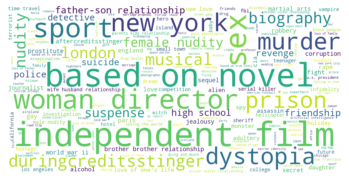

In [68]:
#wordcloud!
wordcloud_args = WordCloud(background_color='white', width=1600, height=800)
wordcloud = wordcloud_args.generate_from_frequencies(keyword_dict)
cloud = wordcloud.to_file('keywords.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### histograms for genres, cast, and director

In [69]:
import seaborn as sns

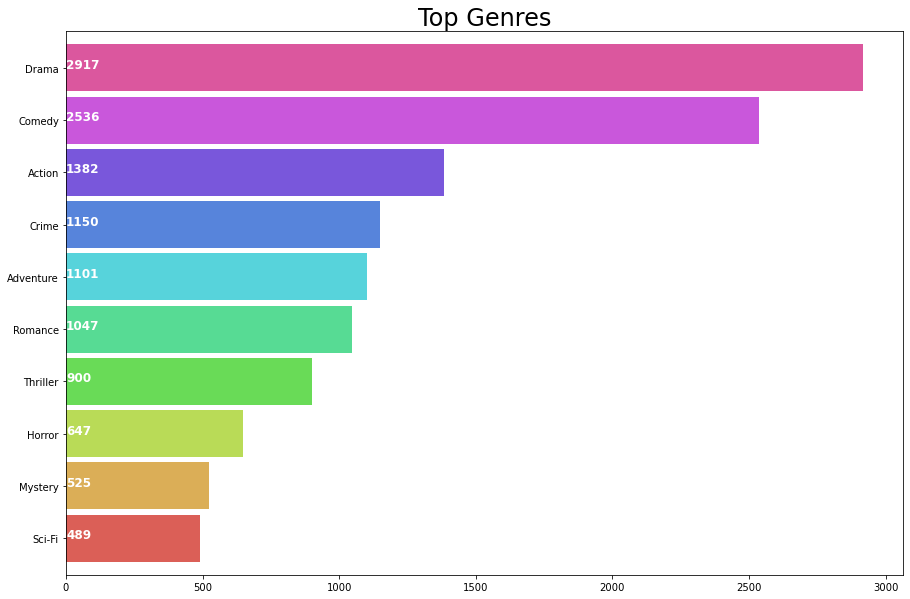

In [70]:
plt.subplots(figsize=(15,10))
list1 = []
for i in imdb_tmdb_movieLens['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres', fontsize=24)
plt.savefig('top genres.png')
plt.show()

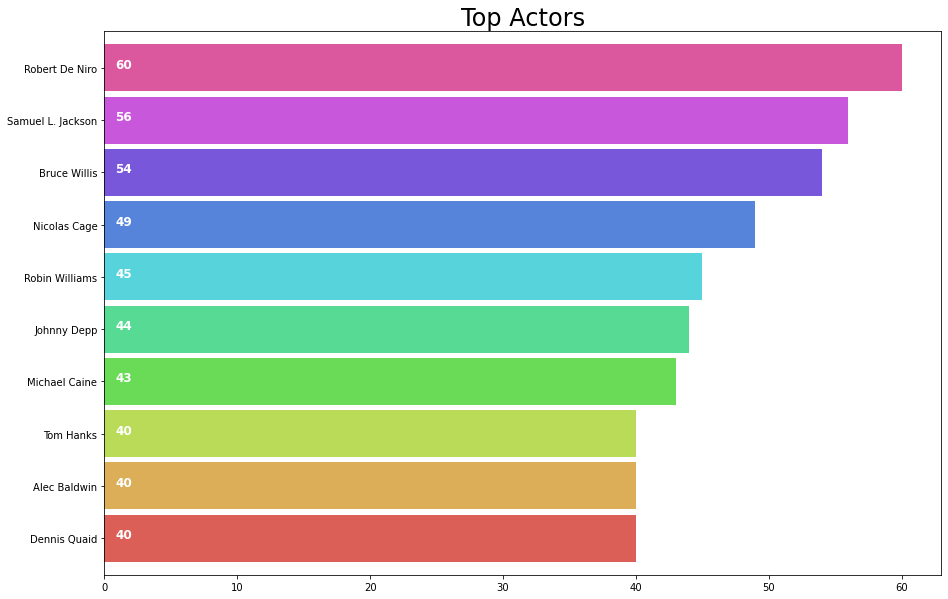

In [71]:
plt.subplots(figsize=(15,10))
list1 = []
for i in imdb_tmdb_movieLens['cast']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Actors', fontsize=24)
plt.savefig('top actors.png')
plt.show()

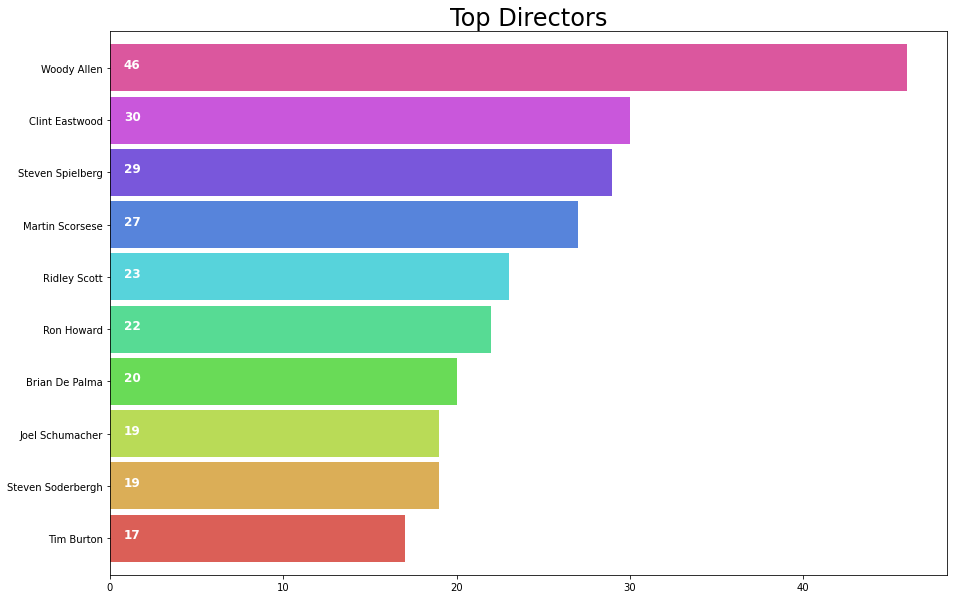

In [72]:
plt.subplots(figsize=(15,10))
list1 = []
for i in imdb_tmdb_movieLens['director']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Directors', fontsize=24)
plt.savefig('top directors.png')
plt.show()